In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

df = pd.read_csv('../StudentsPerformance.csv')

print(df.columns)
print(df.shape)

Index(['gender', 'race/ethnicity', 'parental level of education', 'lunch',
       'test preparation course', 'math score', 'reading score',
       'writing score'],
      dtype='object')
(1000, 8)


In [18]:
df['mean_score'] = df[['math score', 'reading score', 'writing score']].mean(axis=1)

label_encoders = {}
categorical_cols = ['gender', 'race/ethnicity', 'parental level of education', 
                    'lunch', 'test preparation course']

for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

In [19]:
numerical_cols = ['math score', 'reading score', 'writing score', 'mean_score']
scaler = StandardScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

threshold = df['mean_score'].median()
df['target'] = (df['mean_score'] >= threshold).astype(int)

X = df.drop(columns=['target', 'mean_score'])
y = df['target']

In [20]:
# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

In [21]:
# t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X)

Text(0, 0.5, 'Principal Component 2')

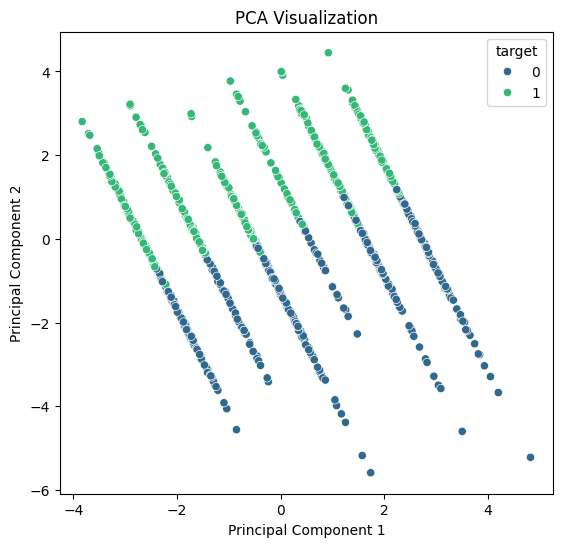

In [22]:
# Визуалізация PCA
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y, palette='viridis', legend='full')
plt.title('PCA Visualization')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

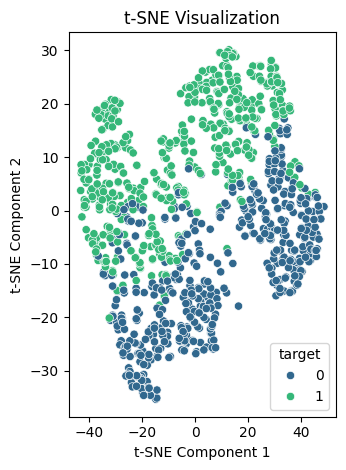

In [23]:
# Визуалізация t-SNE
plt.subplot(1, 2, 2)
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=y, palette='viridis', legend='full')
plt.title('t-SNE Visualization')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')

plt.tight_layout()
plt.show()